In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import gridspec

import hydroeval as he
import h5py
import datetime as dt

sys.path.append('../')
sys.path.append('../pywrdrb/')

from pywrdrb.data_processing.get_results import get_pywr_results, get_base_results

from pywrdrb.pywr_drb_node_data import upstream_nodes_dict

# Custom modules

from pywrdrb.utils.constants import cms_to_mgd, cm_to_mg, cfs_to_mgd
from pywrdrb.utils.lists import reservoir_list, majorflow_list, reservoir_link_pairs
from pywrdrb.utils.directories import input_dir, fig_dir, output_dir, model_data_dir

from pywrdrb.plotting.styles import base_model_colors, model_hatch_styles, paired_model_colors, scatter_model_markers




ModuleNotFoundError: No module named 'pywrdrb.data_processing'

In [2]:
model_type= 'obs_pub_ensemble'
output_dir = '../output_data/'
n_realizations=10
nyc_reservoirs=['cannonsville','neversink', 'pepacton']

ensemble_flows= {}
ensemble_storages= {}
ensemble_downstream= {}

for i in range(10):
    ensemble_flows[f'realization_{i}'] = get_pywr_results(output_dir=output_dir, model=model_type, results_set='major_flow', scenario=i)
    ensemble_storages[f'realization_{i}'] = get_pywr_results(output_dir=output_dir, model=model_type, results_set='res_storage', scenario=i)
    ensemble_downstream[f'realization_{i}'] = get_pywr_results(output_dir=output_dir, model=model_type, results_set='reservoir_downstream_gage', scenario=i)
    

In [48]:
obs_pub_scaled= get_pywr_results(output_dir=output_dir, model='obs_pub_nhmv10_NYCScalingTrue', results_set='res_storage')

In [44]:
nyc_reservoirs=['cannonsville','neversink', 'pepacton']
t_start= '2015-7-01'
t_end= '2017-10-01'


In [51]:

start_date=t_start
end_date=t_end
### get reservoir storage capacities
istarf = pd.read_csv(f'{model_data_dir}drb_model_istarf_conus.csv')
def get_reservoir_capacity(reservoir):
    return float(istarf['Adjusted_CAP_MG'].loc[istarf['reservoir'] == reservoir].iloc[0])
capacities = {r: get_reservoir_capacity(r) for r in nyc_reservoirs}
capacities['combined'] = sum([capacities[r] for r in nyc_reservoirs])

historic_storage = pd.read_csv(f'{input_dir}/historic_NYC/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0, parse_dates=True)
historic_storage.index = pd.to_datetime(historic_storage.index)


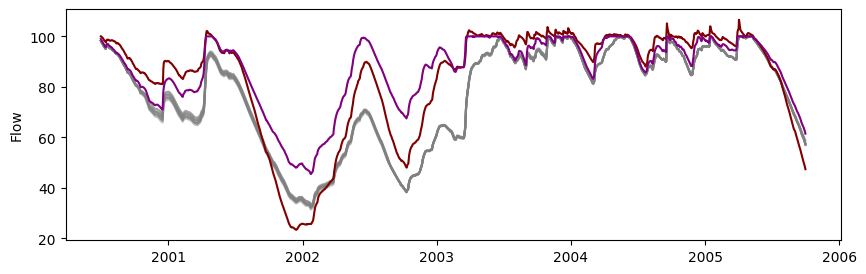

In [53]:

n_realizations=10
t_start= '2000-7-01'
t_end= '2005-10-01'

fig, ax = plt.subplots(figsize=(10,3))

for i in range(n_realizations):
    if i == 0:
        e_mean= ensemble_flows[f'realization_{i}']['delTrenton'].mean() 
    else:
        ensemble_flows[f'realization_{i}']['delTrenton']

for i in range(n_realizations):
    
    ax.plot(ensemble_storages[f'realization_{i}'].loc[t_start:t_end, nyc_reservoirs].sum(axis=1).divide(capacities['combined'])*100, color='grey', alpha=0.5)
    # ax.plot(ensemble_flows[f'realization_{i}'].loc[t_start:t_end,['delTrenton']], color='grey', alpha=0.5)

ax.plot(historic_storage.loc[t_start:t_end, 'PercentageTotal'], color='maroon', alpha=1)
ax.plot(obs_pub_scaled.loc[t_start:t_end, nyc_reservoirs].sum(axis=1).divide(capacities['combined'])*100, color='purple', alpha=1)

# ax.plot()
# ax.hlines(1939, xmin=pd.to_datetime(t_start), xmax=pd.to_datetime(t_end))    
# ax.set_yscale('log')
# ax.set_ylim([1000,3000])
ax.set_ylabel('Flow')
plt.show()

In [34]:
historic_storage.loc[t_start:t_end, 'PercentageTotal']

2003-07-01     99.882939
2003-07-02     99.622969
2003-07-03     99.374446
2003-07-04     99.150665
2003-07-05     99.026588
                 ...    
2003-09-27    100.584934
2003-09-28    101.026588
2003-09-29    101.759970
2003-09-30    101.607459
2003-10-01    101.331241
Name: PercentageTotal, Length: 93, dtype: float64

In [37]:
historic_storage.index

DatetimeIndex(['2000-07-01', '2000-07-02', '2000-07-03', '2000-07-04',
               '2000-07-05', '2000-07-06', '2000-07-07', '2000-07-08',
               '2000-07-09', '2000-07-10',
               ...
               '2003-09-22', '2003-09-23', '2003-09-24', '2003-09-25',
               '2003-09-26', '2003-09-27', '2003-09-28', '2003-09-29',
               '2003-09-30', '2003-10-01'],
              dtype='datetime64[ns]', length=1188, freq=None)

In [19]:

def plot_combined_nyc_storage(storages, releases, models, 
                      start_date = '1999-10-01',
                      end_date = '2010-05-31',
                      colordict = base_model_colors,
                      use_percent = True,
                      plot_drought_levels = True, 
                      plot_releases = True):
    """
    Plot simulated and observed combined NYC reservoir storage.

    Args:
        storages (dict): Dictionary of storage results from `get_pywr_results`.
        releases (dict): Dictionary of release data.
        models (list): List of models to plot.
        start_date (str): Start date of the plot in 'YYYY-MM-DD' format.
        end_date (str): End date of the plot in 'YYYY-MM-DD' format.
        colordict (dict): Dictionary mapping model names to colors (optional).
        use_percent (bool): Whether to plot storage as percentages of capacity (optional).
        plot_drought_levels (bool): Whether to plot drought levels (optional).
        plot_releases (bool): Whether to plot releases (optional).

    Returns:
        None
    """

    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

    ffmp_level_colors = ['blue', 'blue', 'blue', 'cornflowerblue', 'green', 'darkorange', 'maroon']
    drought_cmap = ListedColormap(ffmp_level_colors)

    reservoir_list = ['cannonsville', 'pepacton', 'neversink']

    ### get reservoir storage capacities
    istarf = pd.read_csv(f'{model_data_dir}drb_model_istarf_conus.csv')
    def get_reservoir_capacity(reservoir):
        return float(istarf['Adjusted_CAP_MG'].loc[istarf['reservoir'] == reservoir].iloc[0])
    capacities = {r: get_reservoir_capacity(r) for r in reservoir_list}
    capacities['combined'] = sum([capacities[r] for r in reservoir_list])

    historic_storage = pd.read_csv(f'{input_dir}/historic_NYC/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0)
    historic_storage.index = pd.to_datetime(historic_storage.index)
    historic_storage = historic_storage.loc[start_date:end_date]

    historic_release = pd.read_excel(f'{input_dir}/historic_NYC/Pep_Can_Nev_releases_daily_2000-2021.xlsx', index_col=0)
    historic_release.index = pd.to_datetime(historic_release.index)
    historic_release = historic_release.iloc[:,:3]
    historic_release = historic_release.loc[start_date:end_date] * cfs_to_mgd
    historic_release.columns = ['pepacton','cannonsville','neversink']
    historic_release['Total'] = historic_release.sum(axis=1)

    ### add seasonal min FFMP releases (table 3 https://webapps.usgs.gov/odrm/documents/ffmp/Appendix_A_FFMP-20180716-Final.pdf)
    historic_release['FFMP_min_release'] = 95 * cfs_to_mgd
    historic_release['FFMP_min_release'].loc[[m in (6,7,8) for m in historic_release.index.month]] = 190 * cfs_to_mgd

    model_names = [m[5:] for m in models]
    drought_levels = pd.DataFrame(index= storages[models[0]].index, columns = model_names).loc[start_date:end_date]
    for model in model_names:
        drought_levels[model] = get_pywr_results(output_dir, model, results_set='res_level').loc[start_date:end_date, ['nyc']]

    # Create figure with m subplots
    n_subplots = 3 if plot_releases else 2
    
    fig = plt.figure(figsize=(8, 5), dpi=200)
    gs = gridspec.GridSpec(nrows=n_subplots, ncols=2, width_ratios=[15, 1], height_ratios=[1, 3, 2], wspace=0.05)


    # Plot combined storage
    ax2 = fig.add_subplot(gs[1, 0])
    for m in models:
        if use_percent:
            sim_data = storages[m][reservoir_list].sum(axis=1).loc[start_date:end_date]/capacities['combined']*100
            hist_data = historic_storage.loc[start_date:end_date, 'Total']/capacities['combined']*100
            ylab = f'Storage\n(% Useable)'
        else:
            sim_data = storages[m][reservoir_list].sum(axis=1).loc[start_date:end_date]
            hist_data = historic_storage.loc[start_date:end_date, 'Total']
            ylab = f'Combined NYC Reservoir Storage (MG)'
        ax2.plot(sim_data, color=colordict[m], label=f'{m}')
    ax2.plot(hist_data, color=colordict['obs'], label=f'Observed')
    datetime = sim_data.index
    
    ax2.set_ylabel(ylab, fontsize = 12)
    ax2.yaxis.set_label_coords(-0.1, 0.5) # Set y-axis label position
    ax2.grid(True, which='major', axis='y')
    ax2.set_ylim([0, 110])
    ax2.set_xticklabels([])
    ax2.set_xlim([start_date, end_date])
    
    # Plot releases
    ax3 = fig.add_subplot(gs[2,0])
    for m in models:
        sim_data = releases[m][reservoir_list].sum(axis=1).loc[start_date:end_date]
        sim_data.index = datetime
        ax3.plot(sim_data.index, sim_data, color = colordict[m], label = m, lw = 1)

    ax3.plot(historic_release['Total'], color = colordict['obs'], label=f'Observed', lw = 1)
    ax3.plot(historic_release['FFMP_min_release'], color ='black', ls =':', label = f'FFMP Min. Allowable Combined Release\nAt Drought Level 5')
    ax3.set_yscale('log')
    ax3.yaxis.set_label_coords(-0.1, 0.5)
    ax3.set_ylabel('Releases\n(MGD)', fontsize = 12)
    ax3.set_xlabel('Date', fontsize = 12)
    ax3.set_xlim([start_date, end_date])

    #plt.legend()
    plt.xlabel('Date')
    
    # Create colorbar outside of subplots
    if ax_cbar is not None:
        cbar = ax_cbar.collections[0].colorbar
    plt.legend(loc = 'upper left', bbox_to_anchor=(0., -0.5), ncols=2)
    plt.tight_layout()
    plt.suptitle('Combined NYC Reservoir Operations\nSimulated & Observed')
    plt.savefig(f'{fig_dir}combined_NYC_reservoir_operations_{start_date.strftime("%Y-%m-%d")}_{end_date.strftime("%Y-%m-%d")}.png', dpi=250)
    # plt.show()
    return

In [ ]:
plot_combined_nyc_storage()